# GSE75748 SCale up

Small-scale examinations show promising results. On the way, we corrected the parameter constraints using SLSQP instead of BFGS. SLSQP is in fact more efficient, but was not clear to us since the old log(0) error. Also we find a good enough way to eliminate outliers in 2D, with LocalOutlierFactor provided by scikit-learn.

We will then test all filtered gene pairs for logic gates. With the threshold set to 0.85, we have 36,661 * 2 = 73,322 targets, which is serious load. Notice that preliminary calculations show that the non-linear rate among filtered pairs is large, suggesting even more logic gates can be found is the threshold is lowered. However, due to limited computation power and consensus with former (the GTEx study), we will stick to 0.85 unless a change proves necessary.

The first thing to consider is what to save after the running. The following fields should work:

**Inducer gene, Reporter gene, Keywords, AIC, Delta AIC, Parameters**

The results will be stored in JSON.

First, we will write the filtered genes so that the correlation matrix no longer need to be loaded

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import time
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import pearsonr
import json
from multiprocessing import Pool, cpu_count, Array, RawArray

import sys
sys.path.append("../")
from biologiclib.modelBase import *
from biologiclib.plotUtils import *
from biologiclib.inference import *
from rm_outlier import *
%matplotlib inline

In [2]:
# h9_spearman_corr = pd.read_csv("C:/Users/rainl/vm-storage/graduation_project/GSE75748/h9_spearman_corr.tsv", 
#                                sep = "\t", index_col = 0)

In [3]:
# THRESHOLD = 0.85

# # save only bottom-left triangle
# row_indices_all, col_indices_all = np.where(abs(h9_spearman_corr) > THRESHOLD)
# filtered_indices = [(0, 0) for _ in \
#                     range(int((len(row_indices_all) - h9_spearman_corr.shape[0]) / 2))]
# i = 0
# for row_idx, col_idx in zip(row_indices_all, col_indices_all):
#     if row_idx > col_idx:
#         filtered_indices[i] = (row_idx, col_idx)
#         i += 1
# print(len(filtered_indices), "filtered gene pairs")

36878 filtered gene pairs


In [4]:
# # Save the fitered gene list into tsv
# pd_filtered_indices = pd.DataFrame(filtered_indices, 
#                                    columns = ("inducer_idx", "reporter_idx"))
# pd_filtered_indices.to_csv("../data/GSE75748/filtered_indices.tsv", sep = "\t", index = False)

Find all logic gates

In [3]:
# load expression matrix
h9_tpm = pd.read_csv("../data/GSE75748/h9_imputed.tsv", sep = '\t')
display(h9_tpm.head())
# load filtered indices
filtered_indices = pd.read_csv("../data/GSE75748/filtered_indices.tsv", sep = '\t')
display(filtered_indices.head())

,SRR2977655,SRR2977656,SRR2977657,SRR2977658,SRR2977659,SRR2977660,SRR2977661,SRR2977662,SRR2977663,SRR2977664,...,SRR2977807,SRR2977808,SRR2977809,SRR2977810,SRR2977811,SRR2977812,SRR2977813,SRR2977814,SRR2977815,SRR2977816
ENSG00000000003.14,5.333434,5.401781,5.770235,4.661787,6.163233,5.538727,5.245607,5.342846,5.332342,4.015143,...,5.051099,5.530516,3.392994,5.732665,5.679862,5.603962,5.248733,5.265112,5.444956,3.658732
ENSG00000000005.5,0.405174,1.249968,0.382527,0.368489,0.392334,0.368489,1.645401,0.405174,0.504082,3.131879,...,0.535048,0.719265,0.152943,3.743526,0.602072,3.538463,0.656286,0.690559,3.039113,0.749957
ENSG00000000419.12,4.204045,3.092342,4.310163,4.536766,4.014042,3.381379,4.406172,4.118315,3.951724,3.695306,...,4.643275,3.100543,5.333091,3.417602,4.386976,4.655274,3.856929,4.388999,2.256160,3.578839
ENSG00000000457.13,1.803950,1.249416,0.319675,2.135601,0.757774,2.427578,1.309815,1.590746,3.693367,3.055467,...,3.639198,1.283812,0.285568,0.113242,0.137654,0.535571,3.729450,0.213661,5.374394,0.170811
ENSG00000000460.16,3.753187,0.244273,0.172557,4.943733,4.321864,4.409670,3.152386,3.976263,2.295498,4.773156,...,3.844763,0.964174,4.893142,4.961760,2.728839,4.073061,2.138180,4.200864,3.579143,2.512359


,inducer_idx,reporter_idx
0,202,130
1,338,55
2,478,338
3,793,478
4,1079,919


In [4]:
def extract_results(best_model, all_models):
    specs = [spec.name for spec in best_model.modelSpecs]
    AIC = best_model.IC
    for model in all_models:
        if ModelSpec.Linear in model.modelSpecs:
            linear_model = model
    try:
        Delta_AIC = best_model.IC - linear_model.IC
    except NameError:
        raise Exception('Linear model not found. Abort')
    theta = {key: val for key, val in zip(best_model.thetaKey, best_model.thetaVal)}
    return specs, AIC, Delta_AIC, theta

NUM = 10
detected_logi = []

start_time = time.time()
for idx, row in filtered_indices.head(NUM).iterrows():
    count_inducer_all = np.array(h9_tpm.iloc[row['inducer_idx']])
    count_reporter_all = np.array(h9_tpm.iloc[row['reporter_idx']])
    name_inducer = h9_tpm.index.values[row['inducer_idx']]
    name_reporter = h9_tpm.index.values[row['reporter_idx']]
    # remove outliers
    count_inducer, count_reporter = remove_outliers_2d(count_inducer_all, count_reporter_all)
    # positive or negative correlation
    r, _ = pearsonr(count_inducer, count_reporter)
    if r > 0:
        model_set = ModelSet.Activation_System
    else:
        model_set = ModelSet.Repression_System
    # restore exponential
    count_inducer, count_reporter = np.exp(count_inducer) - 1, np.exp(count_reporter) - 1
    
    # fitting
    best_model_1, all_models_1 = selectModel(count_inducer.reshape(-1, 1), count_reporter,
                            modelSolver = ModelSolver.SLSQP,
                            modelSet = model_set,
                            parallel = False)
    if ModelSpec.Linear not in best_model_1.modelSpecs\
    and len(best_model_1.modelSpecs) != 0:    # then non-linear model
        detected_logi.append(tuple([name_inducer, name_reporter] +\
                              list(extract_results(best_model_1, all_models_1))))
    # fitting, switch inducer and reporter
    best_model_2, all_models_2 = selectModel(count_reporter.reshape(-1, 1), count_inducer,
                            modelSolver = ModelSolver.SLSQP,
                            modelSet = ModelSet.Activation_System,
                            parallel = False)
    if ModelSpec.Linear not in best_model_2.modelSpecs\
    and len(best_model_2.modelSpecs) != 0:    # then non-linear model
        detected_logi.append(tuple([name_reporter, name_inducer] +\
                              list(extract_results(best_model_2, all_models_2))))
elapsed = time.time() - start_time
print("time elapse:", elapsed)
print(len(detected_logi), "logic gates detected")
with open("../data/GSE75748/detected_logi.json", 'w') as fo:
    json.dump(detected_logi, fo)

time elapse: 73.13849568367004
15 logic gates detected


Munally do the first one to check the above script

Best model keywords: ['Michaelis_Menten', 'No_basal_expression', 'Activation']
Best model AIC: -1013.4224178108742
Best model parameters: {'alpha': 0.8509080738256997, 'K': 0.5128193576265804}
Best model expression: A*alpha/(A + K)
Time elapse: 7.316135406494141


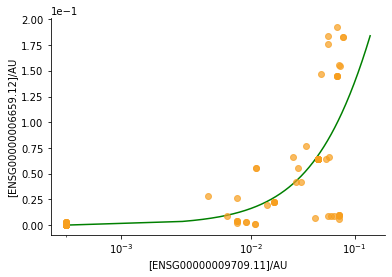

In [5]:
# Pick the first filtered gene pair
inducer_name = h9_tpm.index.values[filtered_indices.iloc[0, 0]]
reporter_name = h9_tpm.index.values[filtered_indices.iloc[0, 1]]

count_inducer_all = np.array(h9_tpm.loc[inducer_name])
count_reporter_all = np.array(h9_tpm.loc[reporter_name])
count_inducer, count_reporter = remove_outliers_2d(count_inducer_all, count_reporter_all)
count_inducer, count_reporter = np.exp(count_inducer) - 1, np.exp(count_reporter) - 1
count_inducer = count_inducer.reshape(-1, 1)

start_time = time.time()
best_model, all_models = selectModel(count_inducer,
                        count_reporter,
                        None,
                        modelSolver = ModelSolver.SLSQP,
                        modelSet = ModelSet.Activation_System,
                        parallel = False)
elapsed = time.time() - start_time
best_model_specs = [spec.name for spec in best_model.modelSpecs]
print("Best model keywords:", best_model_specs)
print("Best model AIC:", best_model.IC)
print("Best model parameters:", 
    {key: val for key, val in zip(best_model.thetaKey, best_model.thetaVal)})
print("Best model expression:", best_model.expression)
print("Time elapse:", elapsed)

plotHelper(count_inducer, count_reporter, best_model,
        inducer_name = inducer_name, reporter_name = reporter_name,
        markersize = 6)

No we will have parallel computing come into play. We will see how much computing time is reduced from the non-parallel version